# Cross Validation -- Model and Hyperparameter Selection

## Outline

<ol>
  <li>Import our dataset that was processed in preprocess_engineer_features.ipynb.</li>
  <li>
    Implement a cross validation approach that:
    <ul>
      <li>Avoids temporal leakage across folds--leave-one-season-out CV</li>
      <li>Determines whether a standard Poisson regression or tree-based approach with Poisson loss minimizes our evaluation metric</li>
      <li>Identifies optimal hyperparameter settings</li>
    </ul>
  </li>
    <li>Visualize the results of our cross validation analysis</li>
    <li>Evaluate our best model on the test set</li>
    <li>Plot residuals and a calibration curve for test set predictions</li>
</ol>

In [ ]:
# Data manipulation 
import numpy as np
import pandas as pd
import polars as pl

# Regression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import PoissonRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from sklearn.metrics import mean_poisson_deviance

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

# Utilities
import os
os.chdir('<YOUR_ROOT_DIRECTORY>') # navigate to the root

from utils.nfl_utils import compute_plot_deviance_residuals, plot_td_calibration

# Saving model
import skops.io as sio

pl.Config(tbl_cols = 50, tbl_rows = 60, set_fmt_str_lengths = 150)

In [ ]:
# Import our data.
qb = pd.read_parquet('<YOUR_DATASETS_DIRECTORY>/qb.parquet')

qb.tail()

,season,week,player_display_name,team,defteam,pass_touchdowns,backup_qb_dummy,wind_speed,implied_points,pass_touchdowns_posterior_mean_ema2_lagged,completion_percentage_ema12_lagged,passer_rating_ema12_lagged,avg_air_yards_differential_ema12_lagged,wind_speed_greater_10_dummy,low_implied_point_total_dummy,low_redzone_completion_percentage_dummy,high_wind_low_expected_point_total_dummy
4290,2024,21,Patrick Mahomes,KC,BUF,1,0,8.0,25.50,1.575819,66.311246,97.013006,-2.400346,0,0,0,0
4291,2024,21,Jalen Hurts,PHI,WAS,1,0,11.0,26.25,1.284815,69.029408,106.664815,-1.921116,1,0,0,0
4292,2024,21,Jayden Daniels,WAS,PHI,1,0,11.0,20.25,1.656499,69.310295,105.611280,-1.648663,1,1,0,1
4293,2024,22,Patrick Mahomes,KC,PHI,3,0,0.0,25.00,1.542817,66.783766,99.415798,-2.264136,0,0,0,0
4294,2024,22,Jalen Hurts,PHI,KC,2,0,0.0,23.50,1.251801,69.425888,107.235654,-1.768894,0,0,0,0


### Let's start with some visuals to get a sense for our target variable's distribution.

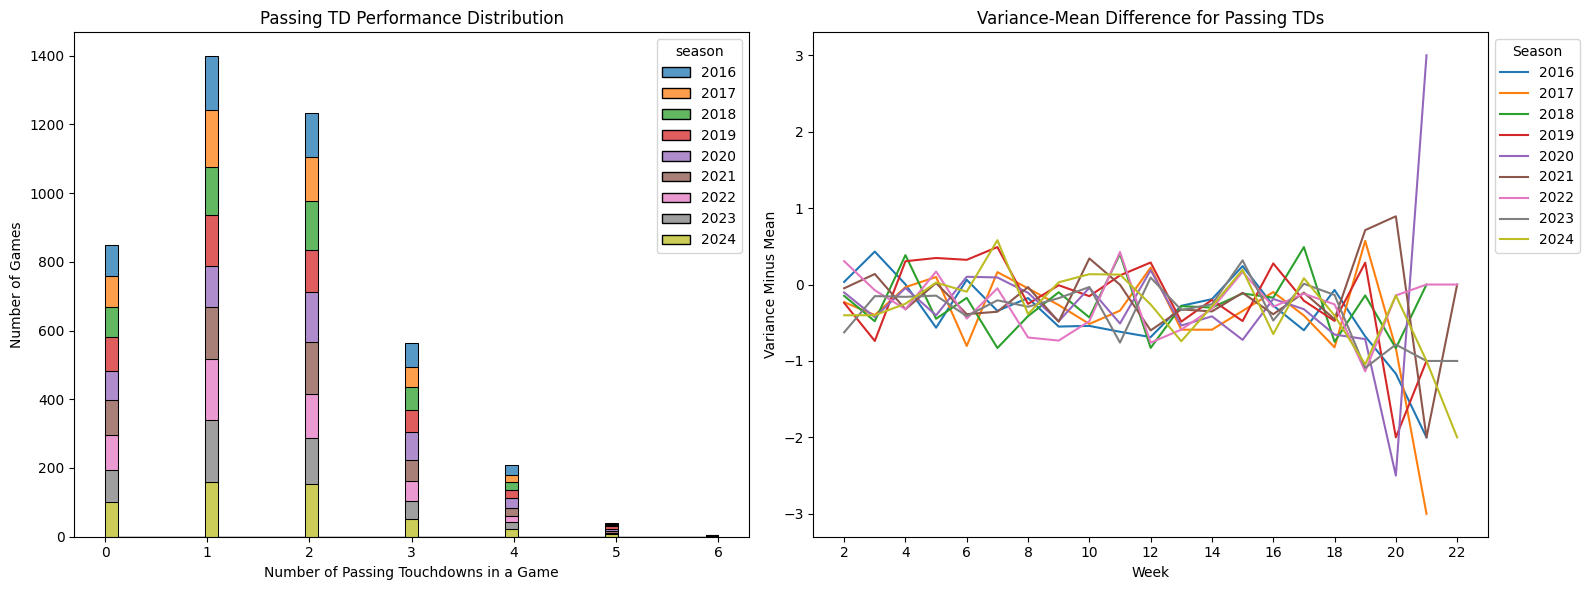

In [3]:
# A couple of basic calculations for our second chart.
qb_mean_var = qb.groupby(['season', 'week'])['pass_touchdowns'].agg(['mean', 'var']).reset_index().rename(columns={'mean': 'mean_pass_td', 'var': 'var_pass_td'})
qb_mean_var['var_m_mean'] = qb_mean_var['var_pass_td'] - qb_mean_var['mean_pass_td']

week_min, week_max = np.min(qb_mean_var['week']), np.max(qb_mean_var['week'])
week_range = np.arange(week_min, week_max)

# Here are the plots.
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Passing TD distribution
sns.histplot(data=qb,x='pass_touchdowns', hue='season', multiple='stack', palette='tab10', ax=axes[0])
axes[0].set_title('Passing TD Performance Distribution')
axes[0].set_xlabel('Number of Passing Touchdowns in a Game')
axes[0].set_ylabel('Number of Games')

# Variance-Mean difference by Week
sns.lineplot(data=qb_mean_var, x='week', y='var_m_mean', hue='season', palette='tab10',ax=axes[1])
axes[1].set_title('Variance-Mean Difference for Passing TDs')
axes[1].set_xlabel('Week')
axes[1].set_ylabel('Variance Minus Mean')
axes[1].legend(title='Season', loc='upper left', bbox_to_anchor=(1, 1))
axes[1].set_xticks(np.arange(week_min, week_max + 1, 2))

plt.tight_layout()
plt.show()

In [4]:
# Let's print out the proportions too.
td_crosstab = pd.crosstab(qb["pass_touchdowns"], qb["season"], normalize="columns")

print('Proportion of passing TD performances by season:\n')
print(tabulate(td_crosstab, headers='keys', tablefmt='grid', showindex=True))

Proportion of passing TD performances by season:

+-------------------+------------+------------+------------+-----------+-----------+-----------+------------+------------+----------+
|   pass_touchdowns |       2016 |       2017 |       2018 |      2019 |      2020 |      2021 |       2022 |       2023 |     2024 |
+===================+============+============+============+===========+===========+===========+============+============+==========+
|                 0 | 0.194915   | 0.191398   | 0.187234   | 0.211207  | 0.18319   | 0.203219  | 0.212679   | 0.194561   | 0.201613 |
+-------------------+------------+------------+------------+-----------+-----------+-----------+------------+------------+----------+
|                 1 | 0.32839    | 0.356989   | 0.3        | 0.321121  | 0.252155  | 0.305835  | 0.366053   | 0.378661   | 0.318548 |
+-------------------+------------+------------+------------+-----------+-----------+-----------+------------+------------+----------+
|           

### A standard Poisson model appears appropriate.

<ul>
    <li>The histogram is skewed right but not with a particularly long tail.</li>
    <li>Outside of later rounds in the playoffs when the number of games each week is very small, the average difference between the variance and the mean appears to be slightly below zero. This rules out a negative binomial model.</li>
    <li>5+ touchdown events are extremely uncommon, accounting for less than one percent of performances, on average, across seasons. This model does not aim to predict tail events, so we will drop them before proceeding.</li>
</ul>

In [5]:
# Remove 5+ TD performances.
qb_0_4 = qb[qb['pass_touchdowns'] < 5]

In [6]:
# Split our dataset.
train_mask = qb_0_4['season'] <= 2022
test_mask = ~train_mask

X = qb_0_4.drop(columns=['week', 'player_display_name', 'team', 'defteam', 'pass_touchdowns'], axis=1)
y = qb_0_4['pass_touchdowns'].to_numpy()

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

# Confirm our split.
total = len(qb_0_4)
print(f'Train dataset is {len(X_train)/total:.2%}')
print(f'Test dataset is {len(X_test)/total:.2%}')

# Get our columns to transform.
cols_dummies = [col for col in X_train if 'dummy' in col]
cols_to_standardize = [col for col in X_train if 'dummy' not in col and 'season' not in col]

# Generate our groups for leave-one-season-out cross validation.
groups = X_train['season'].values

X_train = X_train.drop(columns=['season'], axis=1)
X_test = X_test.drop(columns=['season'], axis=1)

Train dataset is 77.35%
Test dataset is 22.65%


In [7]:
# Here is the setup for our pipeline.
col_transformer = ColumnTransformer([
    ('standardscaler',  StandardScaler(), cols_to_standardize),
    ('passthrough', 'passthrough', cols_dummies),
])

param_grid = [
    {   
        # Standard Poisson                
        'model': [PoissonRegressor(solver='newton-cholesky')],
        'model__max_iter': [100, 250],
        'model__alpha': [1e-3, 1e-2, 1e-1],                  
    },
    {   
        # Tree-based method with Poisson loss                  
        'model': [HistGradientBoostingRegressor(loss='poisson')],
        'model__max_depth': [3, 7], 
        'model__min_samples_leaf': [20],        
        'model__learning_rate': [1e-2, 0.05, 1e-1],       
        'model__l2_regularization': [1e-1],         
    }
]

poisson_pipe = Pipeline([
    ('transform',   col_transformer),
    ('model', PoissonRegressor())
])

# We need a leave-one-season-out CV approach to avoid temporal leakage across folds.
logo = LeaveOneGroupOut()

# Create and run the grid search.
poisson_gs = GridSearchCV(estimator=poisson_pipe, param_grid=param_grid, scoring='neg_mean_poisson_deviance', cv=logo, n_jobs=-1, verbose=1)
poisson_gs.fit(X_train, y_train, groups=groups)

# Print our best CV results.
print('Best CV negative mean Poisson deviance:', poisson_gs.best_score_)
print('Best hyperparameters:', poisson_gs.best_params_)

Fitting 7 folds for each of 12 candidates, totalling 84 fits
Best CV negative mean Poisson deviance: -0.9398569372925857
Best hyperparameters: {'model': PoissonRegressor(solver='newton-cholesky'), 'model__alpha': 0.1, 'model__max_iter': 100}


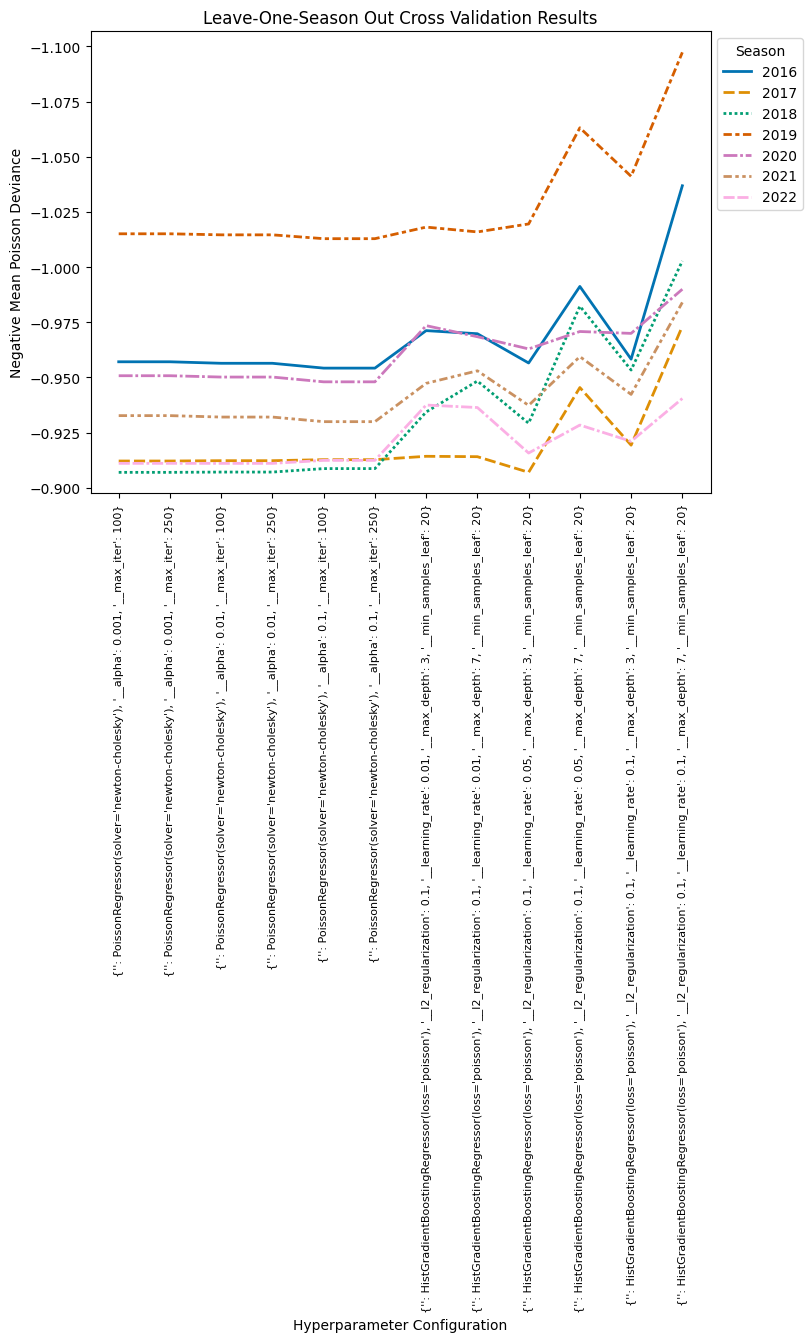

In [8]:
# Let's extract the CV results and plot them.
loso_results = pd.DataFrame(poisson_gs.cv_results_)
loso_splits = loso_results[[col for col in loso_results if 'split' in col and 'test_score' in col]]

# Grab the strings describing hyperparameter settings.
hyperconfigs = poisson_gs.cv_results_['params']
hyperconfigs_clean = [
    {key.replace('model', ''): value for key, value in setting.items()}
    for setting in hyperconfigs
]
    
# Rename the columns and reshape.
loso_splits.columns = ['2016', '2017', '2018', '2019', '2020', '2021', '2022']

# Reshape the data.
loso_splits_plot = loso_splits.copy()
loso_splits_plot['config'] = loso_splits_plot.index
loso_splits_plot = loso_splits_plot.melt(id_vars='config', var_name='Year', value_name='NegTestScore')

# Plot.
plt.figure(figsize=(8, 6))
palette = sns.color_palette("colorblind", n_colors=7)
ax = sns.lineplot(data=loso_splits_plot, x='config', y='NegTestScore', hue='Year', style='Year', linewidth=2, palette=palette)

plt.title('Leave-One-Season Out Cross Validation Results')
plt.ylabel('Negative Mean Poisson Deviance')
plt.xlabel('Hyperparameter Configuration')
plt.xticks(ticks=loso_splits_plot['config'].unique(), labels=hyperconfigs_clean, rotation=90, fontsize=8)
plt.legend(title='Season')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
plt.gca().invert_yaxis()
plt.show()

In [9]:
# Evaluate the best model on the test set and output the mean Poisson deviance, comparing it to a baseline dummy regressor.
best_model = poisson_gs.best_estimator_
y_pred = best_model.predict(X_test)
test_score = mean_poisson_deviance(y_test, y_pred)

dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_train, y_train)
y_baseline_pred = dummy_model.predict(X_test)
baseline_test_score = mean_poisson_deviance(y_test, y_baseline_pred)

print(f'Baseline mean Poisson deviance: {baseline_test_score:}')
print(f'Test set mean Poisson deviance: {test_score}')

Baseline mean Poisson deviance: 0.9624497206923144
Test set mean Poisson deviance: 0.9058668762064825


### The regular Poisson estimator is superior. Some observations...

<ul>
    <li>We see a moderate amount of variation in the mean Poisson deviance from season to season, reflecting unevenness in the target distribution by season and stochasticity in these data.</li>
    <li>The tree-based approach does not perform well. Spikes in the CV score with max depth equal to seven indicate the dataset probably is not large enough to benefit from a complex tree-based algorithm.</li>
    <li>Our specified model clearly outperforms predicting each event using just the mean.</li>
</ul>

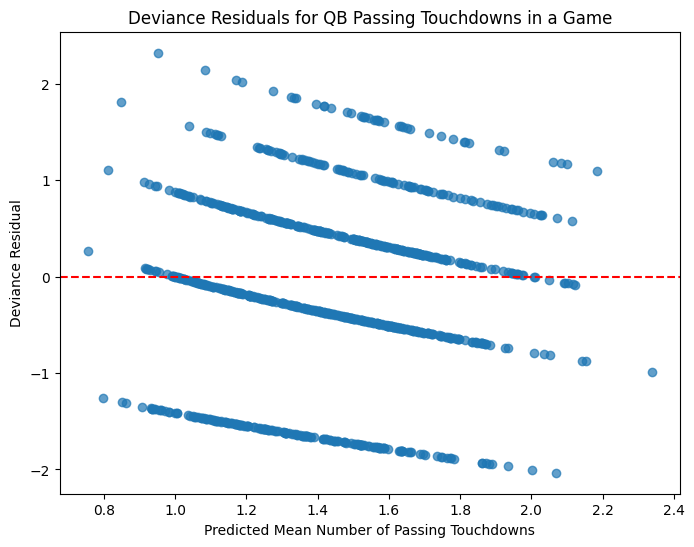

In [10]:
# Compute and plot deviance residuals.
compute_plot_deviance_residuals(y_test, y_pred)

### Deviance residuals show no apparent pattern with a scatter around zero, suggesting the data are fit reasonably well by the model.

In [11]:
# Let's combine our predictions with observed counts to generate a calibration plot.
y_analyze = qb_0_4[['season', 'week', 'player_display_name', 'team', 'defteam', 'pass_touchdowns']].rename(columns={'pass_touchdowns': 'y_true'})

# Test set size.
test_set_index = len(y_pred)

y_analyze_test = y_analyze.tail(test_set_index)
y_analyze_test.loc[:, 'y_pred'] = y_pred

y_analyze_test.tail()

/tmp/ipykernel_13257/2175772413.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_analyze_test.loc[:, 'y_pred'] = y_pred


,season,week,player_display_name,team,defteam,y_true,y_pred
4290,2024,21,Patrick Mahomes,KC,BUF,1,1.699485
4291,2024,21,Jalen Hurts,PHI,WAS,1,1.617485
4292,2024,21,Jayden Daniels,WAS,PHI,1,1.248563
4293,2024,22,Patrick Mahomes,KC,PHI,3,1.711062
4294,2024,22,Jalen Hurts,PHI,KC,2,1.581912


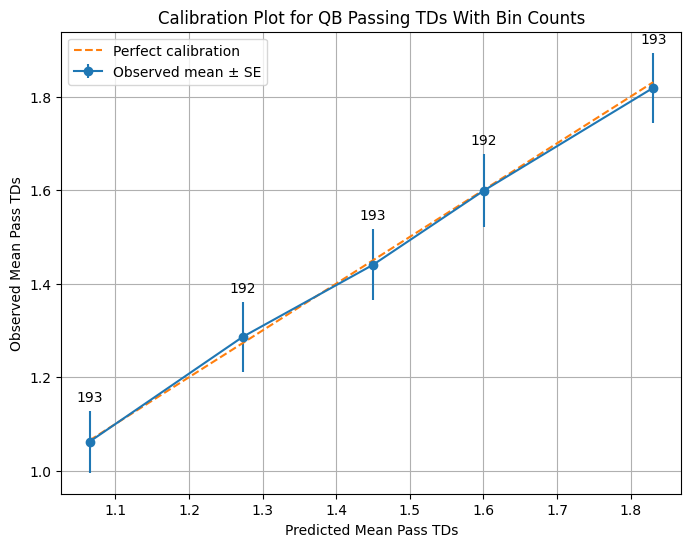

In [12]:
# Here is a calibration curve.
plot_td_calibration(y_analyze_test)

### We are well calibrated. On to simulations...

In [ ]:
# Export X_train, X_test, y_analyze_test, and save our model.
X_train.to_parquet('<YOUR_DATASETS_DIRECTORY>/qb_X_train.parquet')
X_test.to_parquet('<YOUR_DATASETS_DIRECTORY>/qb_X_test.parquet')
y_analyze_test.to_parquet('<YOUR_DATASETS_DIRECTORY>/qb_test_true_pred.parquet')
best_model_save = sio.dump(best_model, '<YOUR_MODELS_DIRECTORY>/qb_poisson_model.skops')